<a href="https://colab.research.google.com/github/econ105/AI/blob/main/AppliedAIvision_llava_4_detecting_plagiarised_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'LLaVA'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (1024/1024), done.
remote: Compressing objects: 100% (408/408), done.
remote: Total 1960 (delta 692), reused 616 (delta 616), pack-reused 936
Receiving objects: 100% (1960/1960), 13.78 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (1238/1238), done.
/content/LLaVA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.4 MB/s eta 0:00:00
    

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

The image is a black and white photograph of a computer screen displaying a line of code. The screen is filled with various symbols, numbers, and letters, creating a complex and intricate pattern. The contrasting black background highlights the intricate details of the code, making it the focal point of the image.


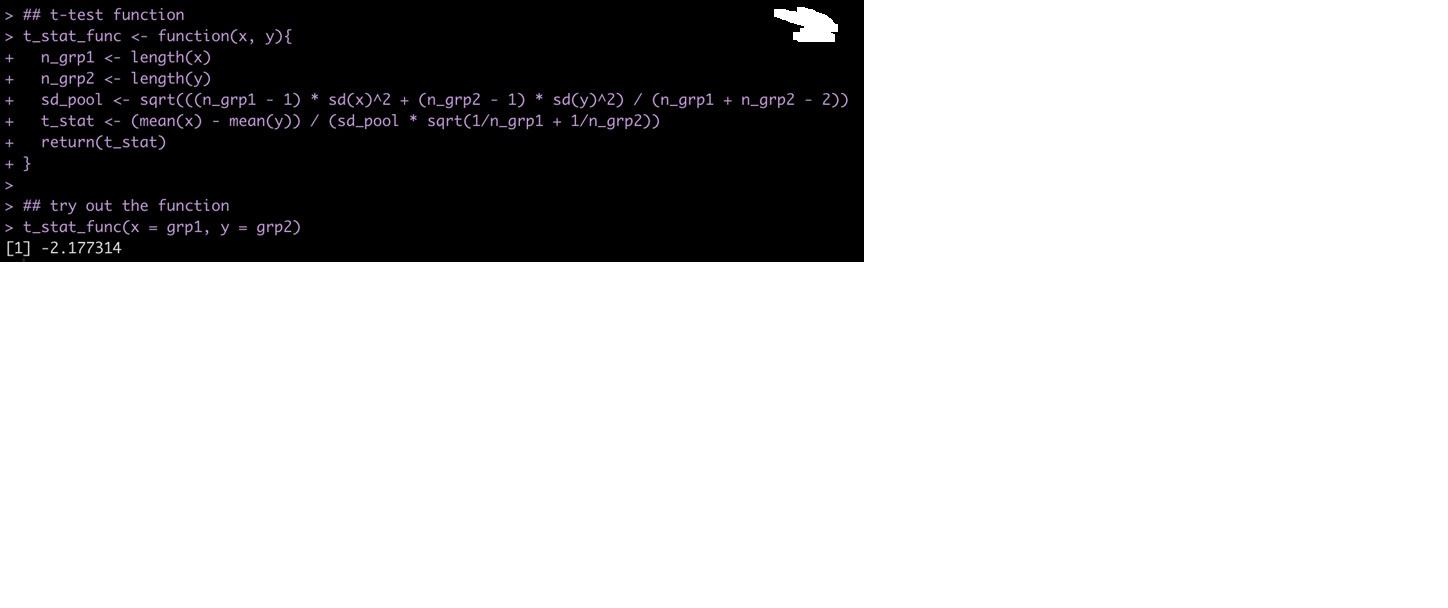

In [ ]:
image, output = caption_image(f'https://i.imgur.com/TBo3csi.jpg', 'Describe the image and color details.')
print(output)
image

In [ ]:
#hereinafter are line-by-line explanation for the above code
#1. `%cd /content`: This line of code changes the current working directory to `/content`.
#2. `!git clone -b v1.0 https://github.com/camenduru/LLaVA`: This line clones the GitHub repository "https://github.com/camenduru/LLaVA" and checks out the v1.0 branch.
#3. `%cd /content/LLaVA`: This line changes the current working directory to `/content/LLaVA`.
#4. `!pip install -q transformers==4.36.2`: This line installs the Transformers library version 4.36.2.
#5. `!pip install -q gradio .`: This line installs the Gradio library.
#6. `from transformers import AutoTokenizer, BitsAndBytesConfig`: This line imports the `AutoTokenizer` and `BitsAndBytesConfig` classes from the Transformers library.
#7. `from llava.model import LlavaLlamaForCausalLM`: This line imports the `LlavaLlamaForCausalLM` class from the `llava.model` module.
#8. `import torch`: This line imports the PyTorch library.
#9. `model_path = "4bit/llava-v1.5-13b-3GB"`: This line sets the `model_path` variable to the path of the pre-trained model.
#10. `kwargs = {"device_map": "auto"}`: This line creates a dictionary `kwargs` with a key-value pair.
#11. `kwargs['load_in_4bit'] = True`: This line adds a new key-value pair to the `kwargs` dictionary.
#12. `kwargs['quantization_config'] = BitsAndBytesConfig(...)`:- This line adds another key-value pair to the `kwargs` dictionary. It sets the value to an instance of the `BitsAndBytesConfig` class with specific configuration parameters.
#13. `model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)`: This line loads the pre-trained model using the `LlavaLlamaForCausalLM` class and the specified parameters.
#14. `tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)`: This line loads the tokenizer for the pre-trained model.
#15. `vision_tower = model.get_vision_tower()`: This line gets the vision tower component from the loaded model.
#16. `if not vision_tower.is_loaded:`: This line checks if the vision tower is already loaded.
#17. `vision_tower.load_model()`: This line loads the vision tower model if it is not already loaded.
#18. `vision_tower.to(device='cuda')`: This line moves the vision tower to the CUDA device for GPU acceleration.
#19. `image_processor = vision_tower.image_processor`: This line assigns the image processor component from the vision tower to the `image_processor` variable.
#20. `import os, requests, from PIL import Image, from io import BytesIO`: These lines import necessary modules for handling images.
#21. `from llava.conversation import conv_templates, SeparatorStyle`: This line imports the conversation templates and SeparatorStyle from the `llava.conversation` module.
#22. `from llava.utils import disable_torch_init`: This line imports the `disable_torch_init` function from the `llava.utils` module.
#23. `from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN`: This line imports constants related to image tokens and conversation prompts from the `llava.constants` module.
#24. `from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria`: This line imports utility functions and classes related to multimodal processing from the `llava.mm_utils` module.
#25. `from transformers import TextStreamer`: This line imports the `TextStreamer` class from the Transformers library.
#26. `def caption_image(image_file, prompt):`: This line defines a function named `caption_image` that takes an image file path and a prompt as input.
#27. The remaining lines of code within the `caption_image` function perform the following tasks:- Load the image from the file or URL.- Initialize a conversation template.- Preprocess the image and generate input tokens.
# Use the loaded model to generate a caption for the image given the prompt.Decode the generated output tokens and return the image and caption.
